# Lesson 38: Text data analysis demonstration

This notebook demonstrates key concepts and tools for text data analysis in NLP.

**1. Text preprocessing**
- Tokenization
- Normalization and cleaning
- Stemming and lemmatization

**2. Text exploration**
- Word frequency analysis
- Word cloud visualization

**3. Text classification**
- Naive Bayes classifier

**4. Rule-based sentiment analysis**
- VADER sentiment analyzer


## Notebook set up

**Note**: depending on your environment, you may need to install NLTK and wordcloud:

```text
pip install nltk wordcloud
```

### Imports

In [17]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, movie_reviews
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('movie_reviews', quiet=True)
nltk.download('vader_lexicon', quiet=True)

True

### Dataset

We use the NLTK movie reviews corpus, which contains 2000 movie reviews labeled as positive or negative.

In [18]:
# Load movie reviews corpus
documents = [(movie_reviews.raw(fileid), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

# Create dataframe
df = pd.DataFrame(documents, columns=['text', 'label'])

print(f'Dataset shape: {df.shape}')
print(f'Label distribution:\n{df["label"].value_counts()}')
df.head()

Dataset shape: (2000, 2)
Label distribution:
label
neg    1000
pos    1000
Name: count, dtype: int64


,text,label
0,"plot : two teen couples go to a church party ,...",neg
1,the happy bastard's quick movie review \ndamn ...,neg
2,it is movies like these that make a jaded movi...,neg
3,""" quest for camelot "" is warner bros . ' firs...",neg
4,synopsis : a mentally unstable man undergoing ...,neg


## 1. Text preprocessing

### 1.1. Tokenization

Tokenization splits text into individual units (tokens) such as words or sentences.

NLTK [word_tokenize](https://www.nltk.org/api/nltk.tokenize.html) documentation

In [19]:
# Sample text for demonstration
sample_text = df['text'].iloc[0][:500]

# Word tokenization
word_tokens = word_tokenize(sample_text)

# Sentence tokenization
sent_tokens = sent_tokenize(sample_text)

print(f'Original text:\n{sample_text}\n')
print(f'Word tokens ({len(word_tokens)} tokens):\n{word_tokens[:20]}...\n')
print(f'Sentence tokens ({len(sent_tokens)} sentences):\n{sent_tokens[:2]}')

Original text:
plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt

Word tokens (106 tokens):
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.', 'they', 'get', 'into', 'an']...

Sentence tokens (9 sentences):
['plot : two teen couples go to a church party , drink and then drive .', 'they get into an accident .']


### 1.2. Normalization and cleaning

Text normalization includes lowercasing, removing punctuation, and filtering stopwords.

In [20]:
# Lowercase
tokens_lower = [token.lower() for token in word_tokens]

# Remove non-alphabetic tokens
tokens_alpha = [token for token in tokens_lower if token.isalpha()]

# Remove stopwords
stop_words = set(stopwords.words('english'))
tokens_clean = [token for token in tokens_alpha if token not in stop_words]

print(f'Original tokens: {len(word_tokens)}')
print(f'After lowercasing: {len(tokens_lower)}')
print(f'After removing non-alpha: {len(tokens_alpha)}')
print(f'After removing stopwords: {len(tokens_clean)}')
print(f'\nCleaned tokens:\n{tokens_clean[:15]}')

Original tokens: 106
After lowercasing: 106
After removing non-alpha: 87
After removing stopwords: 45

Cleaned tokens:
['plot', 'two', 'teen', 'couples', 'go', 'church', 'party', 'drink', 'drive', 'get', 'accident', 'one', 'guys', 'dies', 'girlfriend']


### 1.3. Stemming and lemmatization

Stemming reduces words to their root form by removing suffixes. Lemmatization reduces words to their dictionary form (lemma).

NLTK [PorterStemmer](https://www.nltk.org/api/nltk.stem.porter.html) and [WordNetLemmatizer](https://www.nltk.org/api/nltk.stem.wordnet.html) documentation

In [22]:
# Stemming
stemmer = PorterStemmer()
tokens_stemmed = [stemmer.stem(token) for token in tokens_clean]

# Lemmatization
lemmatizer = WordNetLemmatizer()
tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_clean]

# Compare results
comparison_df = pd.DataFrame({
    'original': tokens_clean[:50],
    'stemmed': tokens_stemmed[:50],
    'lemmatized': tokens_lemmatized[:50]
})

comparison_df

,original,stemmed,lemmatized
0,plot,plot,plot
1,two,two,two
2,teen,teen,teen
3,couples,coupl,couple
4,go,go,go
5,church,church,church
6,party,parti,party
7,drink,drink,drink
8,drive,drive,drive
9,get,get,get


## 2. Text exploration

### 2.1. Word frequency analysis

In [6]:
# Preprocess function for full corpus
def preprocess_text(text):

    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return tokens

# Get all tokens from corpus
all_tokens = []

for text in df['text']:
    all_tokens.extend(preprocess_text(text))

# Count word frequencies
word_freq = Counter(all_tokens)
top_20 = word_freq.most_common(20)

# Display top words
freq_df = pd.DataFrame(top_20, columns=['word', 'count'])
freq_df

,word,count
0,film,9443
1,movie,5671
2,one,5582
3,like,3547
4,even,2556
5,good,2316
6,time,2282
7,would,2264
8,story,2146
9,much,2024


### 2.2. Word cloud visualization

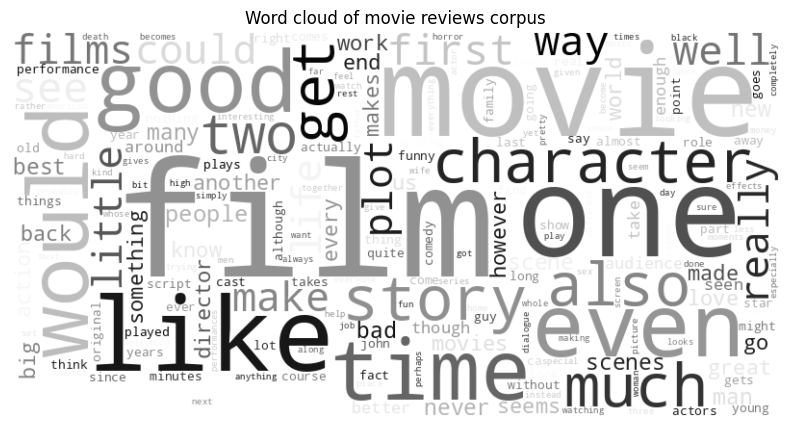

In [23]:
# Create word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Greys'
).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.title('Word cloud of movie reviews corpus')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

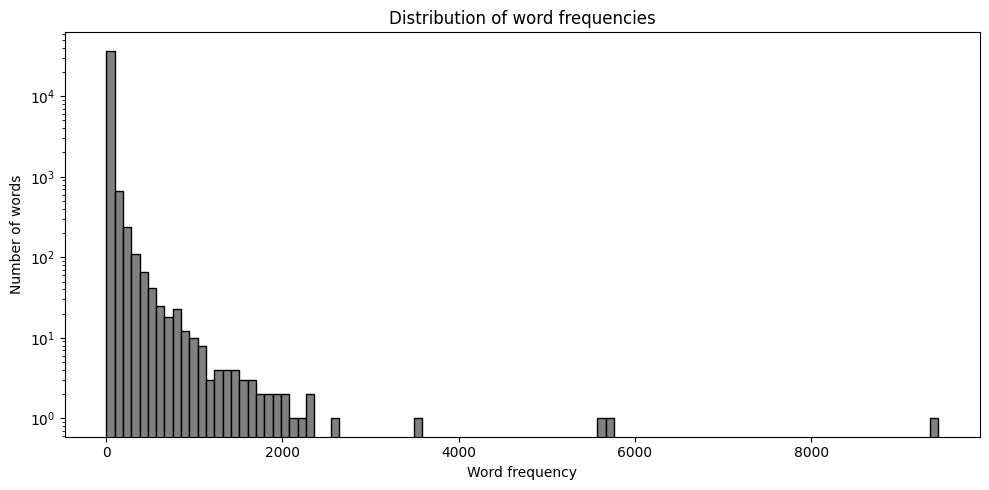

In [15]:
# Histogram of word frequency distribution
word_counts = list(word_freq.values())

plt.figure(figsize=(10, 5))
plt.title('Distribution of word frequencies')
plt.hist(word_counts, bins=100, color='grey', edgecolor='black')
plt.xlabel('Word frequency')
plt.ylabel('Number of words')
plt.yscale('log')  # Use logarithmic scale for better visibility
plt.tight_layout()
plt.show()

## 3. Text classification

### 3.1. Naive Bayes classifier

Naive Bayes is a simple but effective classifier for text that uses word frequencies as features.

Scikit-learn [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) documentation

In [24]:
# Prepare data
X = df['text']
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=315
)

# Vectorize text using bag-of-words
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f'Training set: {X_train_vec.shape}')
print(f'Test set: {X_test_vec.shape}')

Training set: (1600, 5000)
Test set: (400, 5000)


In [25]:
# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

# Predict and evaluate
y_pred = nb_classifier.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.3f}\n')
print('Classification report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.812

Classification report:
              precision    recall  f1-score   support

         neg       0.80      0.84      0.82       202
         pos       0.83      0.78      0.81       198

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



## 4. Rule-based sentiment analysis

### 4.1. VADER sentiment analyzer

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon-based sentiment analyzer that uses a dictionary of words with pre-assigned sentiment scores.

NLTK [VADER](https://www.nltk.org/howto/sentiment.html) documentation

In [31]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Example sentences
example_texts = [
    'This movie was absolutely fantastic! I loved every minute.',
    'Terrible film. Complete waste of time and money.',
    'The movie was okay. Nothing special but watchable.',
    'I have mixed feelings about this one.'
]

# Analyze sentiment
print('VADER sentiment scores:\n')

for text in example_texts:

    scores = sia.polarity_scores(text)
    print(f'Text: {text}')
    print(f'Scores: {scores}\n')

VADER sentiment scores:

Text: This movie was absolutely fantastic! I loved every minute.
Scores: {'neg': 0.0, 'neu': 0.418, 'pos': 0.582, 'compound': 0.8542}

Text: Terrible film. Complete waste of time and money.
Scores: {'neg': 0.496, 'neu': 0.504, 'pos': 0.0, 'compound': -0.7096}

Text: The movie was okay. Nothing special but watchable.
Scores: {'neg': 0.179, 'neu': 0.661, 'pos': 0.16, 'compound': -0.0462}

Text: I have mixed feelings about this one.
Scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}



### 4.2. VADER evaluation on corpus

In [32]:
# Apply VADER to test set
def vader_predict(text):

    scores = sia.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'pos'
    elif scores['compound'] <= -0.05:
        return 'neg'
    else:
        return 'neg'  # Default to negative for neutral

# Predict with VADER
y_pred_vader = [vader_predict(text) for text in X_test]
vader_accuracy = accuracy_score(y_test, y_pred_vader)

print(f'VADER accuracy: {vader_accuracy:.3f}')
print(f'Naive Bayes accuracy: {accuracy:.3f}')

VADER accuracy: 0.632
Naive Bayes accuracy: 0.812
